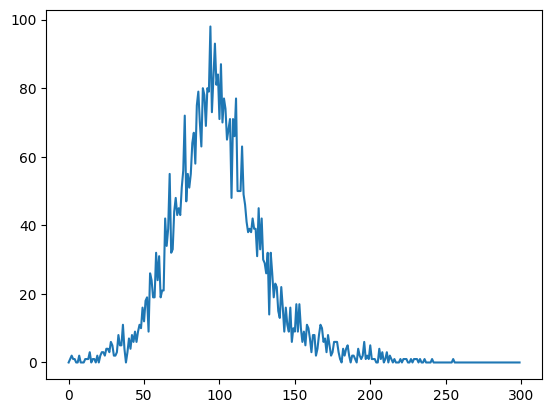

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

param = {'beta':0.2,'gamma':1/14,'eta':1/7,'q':0.1,'mu':0.004}

rng = np.random.default_rng()


def RHS(state):

        """RHS function for the tau-leaping methodology. 
        
        Args: 
            particle: A single particle in the particle list. 
            ctx: The algorithm's Context, used to obtain the rng. 
            tau: A parameter governing the length of time on which to generate the poisson draws. 
        
        """

        S,E,I,R = state
        N = S+E+I+R

        dN_SE = rng.poisson(((param['beta'] * E + param['q'] * I)/N) * S)
        dN_EI =  rng.poisson(param['eta'] * E)
        dN_ER = rng.poisson(param['gamma'] * E)
        dN_IR = rng.poisson(param['gamma'] * I)
        dN_ID = rng.poisson(param['mu'] * I)
        
            
        state = np.zeros_like(state)
        '''Enforces the minimum will be 0'''
        state[0] = max(0.,S-dN_SE)
        state[1] = max(0.,E + dN_SE - dN_EI - dN_ER)
        state[2] = max(0.,I + dN_EI - dN_IR - dN_ID)
        state[3] = max(0.,R + dN_IR + dN_ER)
        return state,dN_EI

state = []
obs = []
state.append([10000,5,5,0])
for i in range(300):
    result,o = RHS(state[-1])
    state.append(result)
    obs.append(o) 

state = np.array(state)

plt.plot(obs) 

pd.DataFrame(obs).to_csv('../datasets/test_leaping.csv')



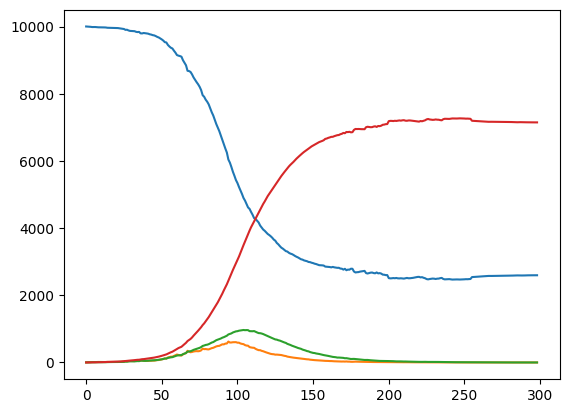

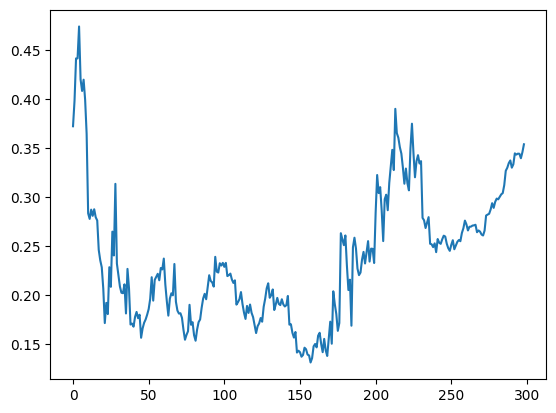

In [25]:
'''Entry point for the particle filtering code '''

import sys
sys.path.append('../')




from Implementations.algorithms.Bootstrap import Bootstrap,Stats
from Implementations.resamplers.resamplers import LogNBinomResample
from Implementations.solvers.StochasticSolvers import CalvettiTau
from Implementations.perturbers.pmcmc_perturb import PMMH_Perturb
from utilities.Utils import Context,ESTIMATION
from functools import partial
from scipy.stats import uniform,lognorm,beta
import matplotlib.pyplot as plt



'''Algorithm object encapsulating all the requirements'''
algo = Bootstrap(integrator = CalvettiTau(),
                        perturb = PMMH_Perturb(hyper_params={"sigma1":0.01,"sigma2":0.1}),
                        resampler = LogNBinomResample(),
                        ctx=Context(population=10010,
                                    state_size = 4,
                                    weights=np.zeros(1000),
                                    seed_loc=[1,2],
                                    estimation_size=1,
                                    seed_size=5,
                                    rng=np.random.default_rng(),
                        particle_count=100))

algo.initialize(params={
"beta":ESTIMATION.VARIABLE,
"gamma":ESTIMATION.PMCMC,
"eta":ESTIMATION.PMCMC,
"mu":0.004,
"q":0.1,
"R":100,
"alpha":0.1,
}


,priors={"beta":partial(algo.ctx.rng.uniform,0.1,0.6), 
          "gamma":1/14,
          "eta":1/7,
          })


#algo.print_particles()
output = algo.run(f'../datasets/test_leaping.csv',299)

plt.plot(output.state)
plt.show()
plt.plot(output.beta)


In [35]:
'''First set theta'''

rng = np.random.default_rng()

gamma_0 = rng.uniform(0,0.3)
eta_0 = rng.uniform(0,0.3)

'''Run SMC'''

'''Algorithm object encapsulating all the requirements'''
algo = Bootstrap(integrator = CalvettiTau(),
                        perturb = PMMH_Perturb(hyper_params={"sigma1":0.01,"sigma2":0.1}),
                        resampler = LogNBinomResample(),
                        ctx=Context(population=100_000,
                                    state_size = 4,
                                    weights=np.zeros(1000),
                                    seed_loc=[1,2],
                                    estimation_size=1,
                                    seed_size=5,
                                    rng=np.random.default_rng(),
                        particle_count=200))

algo.initialize(params={
"beta":0.2,
"gamma":ESTIMATION.PMCMC,
"eta":ESTIMATION.PMCMC,
"mu":0.004,
"q":0.1,
"R":100,
"alpha":0.1,
}


,priors={"beta":partial(algo.ctx.rng.uniform,0.1,0.6), 
          "gamma":0.9,
          "eta":0.9,
          })

output = algo.run(f'../datasets/calvetti_sim_data_protocol_A.csv',119)

iters = 1000

gammas = []
gammas.append(0.5)
etas = []
etas.append(0.5)
LL = []
LL.append(output.log_likelihood)

for i in range(iters): 
    gamma_prop = rng.normal(gammas[-1],0.1)
    eta_prop = rng.normal(etas[-1],0.1)

    gamma_prop = max(0,gamma_prop)
    eta_prop = max(0,eta_prop)

    if(gamma_prop != 0 and eta_prop != 0): 
        output = algo.initialize(params={
        "beta":0.2,
        "gamma":ESTIMATION.PMCMC,
        "eta":ESTIMATION.PMCMC,
        "mu":0.004,
        "q":0.1,
        "R":100,
        "alpha":0.1,
        }

        ,priors={"beta":partial(algo.ctx.rng.uniform,0.1,0.6), 
            "gamma":gamma_prop,
            "eta":eta_prop,
            })

        output = algo.run(f'../datasets/test_leaping.csv',250)

        log_density_prop = output.log_likelihood
    else: 
       log_density_prop -50000
    
    log_density_last = LL[-1]

    accept = min(1, np.exp((log_density_prop) - (log_density_last)))

    check = rng.uniform(0,1)
    if check < accept: 
      print(f"accepted w/ {output.log_likelihood}: ",gamma_prop,eta_prop)
      LL.append(output.log_likelihood)
      gammas.append(gamma_prop)
      etas.append(eta_prop)
    else: 
       print("Not accepted")
    


Not accepted
Not accepted


/var/folders/ls/yd1_54l95jq3d4wpt_5mrz980000gn/T/ipykernel_1903/3939321419.py:81: RuntimeWarning: overflow encountered in exp
  accept = min(1, np.exp((log_density_prop) - (log_density_last)))


accepted w/ -3373.2580335390066:  0.6435875770486762 0.41930740782829357
Not accepted
Not accepted
accepted w/ -2782.4343241423494:  0.7418657927539185 0.40084723364572644
Not accepted
accepted w/ -2590.2946444977597:  0.7844694427968395 0.3263223088540447


/var/folders/ls/yd1_54l95jq3d4wpt_5mrz980000gn/T/ipykernel_1903/3939321419.py:81: RuntimeWarning: overflow encountered in exp
  accept = min(1, np.exp((log_density_prop) - (log_density_last)))


accepted w/ -1381.634329429669:  0.980016844393001 0.09270623966297756
accepted w/ -1337.2229593717043:  1.2062616396937313 0.009593111404981702
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accept

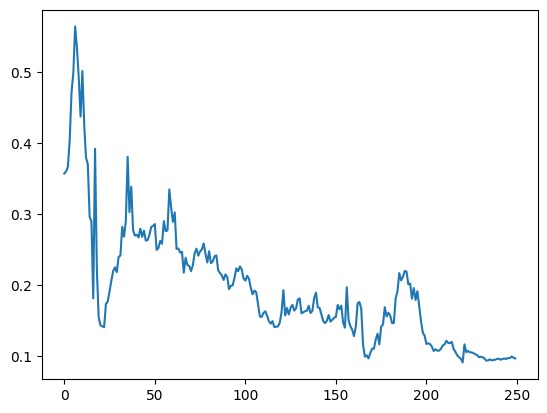

In [ ]:
import matplotlib.pyplot as plt

plt.plot(output.beta)
plt.show()